Text(0.5,1,u'AV..csv')

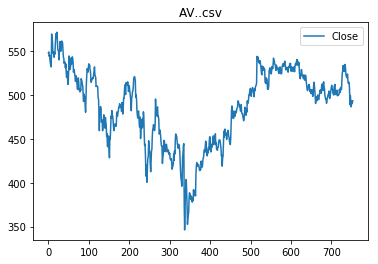

In [21]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np, numpy.random
import cvxopt as opt
from cvxopt import blas, solvers
import os, random

assets = [] # 3 random assets' expected return
# read a random file
rand_stocks = []
rand_stock = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock)
df1 = pd.read_csv('stock_dfs/'+rand_stock, usecols=['Date', 'Close'])
# df1 = pd.read_csv('stock_dfs/RRS.csv', usecols=['Date', 'Close'])
df1.plot()
plt.title(rand_stock)
# df1.head()

In [22]:
## use first half of 3 stocks to find expected return and covariances
# asset's first half expected return function
def half_expected_return(df, assets):
    df = df[:-len(df)/2] # drop second half
    returns = (df.Close - df.Close.shift(1))/df.Close
    returns = returns.dropna()
    assets.append(returns.mean())
    
    return returns
returns1 = half_expected_return(df1, assets)
# print returns1
print assets

[-0.0009608974684723751]


Text(0.5,1,u'SSE.csv')

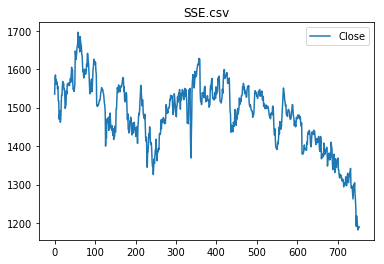

In [23]:
rand_stock2 = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock2)
df2 = pd.read_csv('stock_dfs/'+rand_stock2, usecols=['Date', 'Close'])
# df2 = pd.read_csv('stock_dfs/III.csv', usecols=['Date', 'Close'])
df2.plot()
plt.title(rand_stock2)
# df2.head()

In [24]:
returns2 = half_expected_return(df2, assets)
print assets

[-0.0009608974684723751, -0.00013084634737985516]


[-0.0009608974684723751, -0.00013084634737985516, -0.0013198093882105257]


Text(0.5,1,u'TSCO.csv')

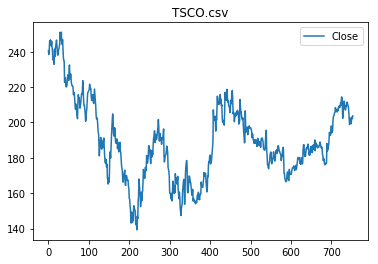

In [25]:
rand_stock3 = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock3)
df3 = pd.read_csv('stock_dfs/'+rand_stock3, usecols=['Date', 'Close'])
# df3 = pd.read_csv('stock_dfs/ADM.csv', usecols=['Date', 'Close'])
returns3 = half_expected_return(df3, assets)
print assets
df3.plot()
plt.title(rand_stock3)

In [26]:
# find covariance of 3 assets
C = np.cov(np.array([returns1.values, returns2.values, returns3.values]))
print C

[[0.00044488 0.00018517 0.00021624]
 [0.00018517 0.000215   0.00012648]
 [0.00021624 0.00012648 0.00044805]]


     pcost       dcost       gap    pres   dres
 0:  8.0348e-04 -7.3345e+00  7e+00  2e-16  4e-16
 1:  8.0303e-04 -7.4278e-02  8e-02  2e-16  5e-16
 2:  7.6018e-04 -1.6434e-03  2e-03  2e-16  2e-17
 3: -5.1539e-05 -4.3944e-04  4e-04  1e-16  2e-18
 4: -2.2503e-04 -2.3100e-04  6e-06  1e-16  4e-19
 5: -2.2804e-04 -2.2809e-04  6e-08  3e-16  1e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.2362e-04 -7.3346e+00  7e+00  7e-17  2e-16
 1:  9.2309e-04 -7.4237e-02  8e-02  3e-16  3e-16
 2:  8.7358e-04 -1.5748e-03  2e-03  2e-16  1e-17
 3:  1.7455e-04 -4.7547e-05  2e-04  1e-16  5e-19
 4:  1.4248e-04  1.2381e-04  2e-05  1e-16  2e-19
 5:  1.4049e-04  1.3980e-04  7e-07  4e-16  5e-19
 6:  1.4047e-04  1.4047e-04  7e-09  2e-16  4e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0438e-03 -7.3347e+00  7e+00  1e-16  4e-16
 1:  1.0431e-03 -7.4196e-02  8e-02  1e-16  7e-16
 2:  9.8644e-04 -1.5050e-03  2e-03  1e-16  2e-17
 3:  3.5935e-04  1.5182e

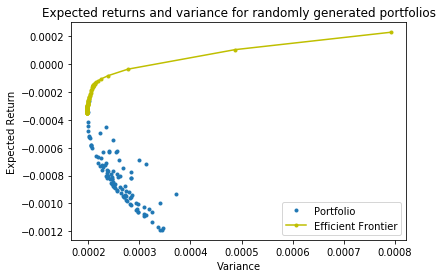

In [27]:
## find efficient frontier
# generate random portfolio, see random_portfolio notebook
np.random.seed(2) # fixed random seed
n_portfolio = 100 # number of portfolios
n_asset = len(assets) # number of assets 3
rand_matrix = np.random.random((n_portfolio, n_asset)) # generate random matrix
portfolio = np.zeros((n_portfolio, n_asset)) # create portfolios
i = 0
for row in rand_matrix: # each portfolio sum up to 1
    row_sum = np.sum(row)
    j = 0
    for col in row:
        portfolio[i][j] = col/row_sum
        j += 1
    i += 1
E = np.dot(portfolio, assets) # find expected return of each portfolio
variance = np.zeros((n_portfolio, 1)) # find variance of all portfolio
i = 0
for row in portfolio:
    variance[i] = np.dot(np.dot(row, C), row.T)
    i += 1
    
fig, ax = plt.subplots()
plotfolios = ax.plot(variance, E, 'o', markersize=3, label='Portfolio')
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.title('Expected returns and variance for randomly generated portfolios')

N = 100
points = [t for t in range(N)] # find max return for 100 points
S = opt.matrix(C)
q = opt.matrix(assets, (3, 1)) # mean return of 3 assets

G = -opt.matrix(np.eye(n_asset)) # all 3 portions >= 0
oo = opt.matrix([-G, G], (6, 3))
h = opt.matrix(1.0, (6, 1))
A = opt.matrix(1.0, (1, n_asset)) # all 3 portions sum to 1
b = opt.matrix(1.0)

portfolios = [solvers.qp(x*S, -q, oo, h, A, b)['x'] for x in points]
returns = [blas.dot(q, x) for x in portfolios] # for each efficient portfolio
risks = [blas.dot(x, S*x) for x in portfolios]

frontier = ax.plot(risks, returns, 'y-o', markersize=3, label='Efficient Frontier')
ax.legend(loc='best')

In [28]:
assets2 = []
# take second half of assets
def half2_expected_return(df, assets):
    df = df[len(df)/2:] # drop first half
    returns = (df.Close - df.Close.shift(1))/df.Close
    returns = returns.dropna()
    assets2.append(returns.mean())
    return returns
returns1 = half2_expected_return(df1, assets2)
print assets2
# print returns1

[0.0003998211864264135]


In [29]:
returns2 = half2_expected_return(df2, assets2)
print assets2

[0.0003998211864264135, -0.000712596899383333]


In [30]:
returns3 = half2_expected_return(df3, assets2)
print assets2

[0.0003998211864264135, -0.000712596899383333, 0.0005172278924098779]


In [31]:
# find covariance of 3 assets second half
C2 = np.cov(np.array([returns1.values, returns2.values, returns3.values]))
print C2

[[1.09286885e-04 1.10196263e-05 3.57574302e-05]
 [1.10196263e-05 1.10101948e-04 1.60204310e-05]
 [3.57574302e-05 1.60204310e-05 2.64240430e-04]]


Text(0.5,1,u'Expected returns and variance for naive portfolios')

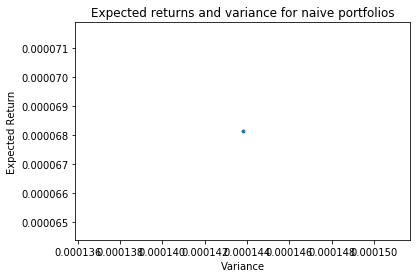

In [32]:
n_portfolio = 1 # number of portfolios
n_asset = len(assets2) # number of assets 3
naive = np.full((n_portfolio, n_asset), 1.0/3) # generate Naive Diversification
E = np.dot(naive, assets2) # find expected return of each portfolio
variance2 = np.dot(np.dot(row, C2), row.T) # find variance of all portfolio
variance2

fig2, ax2 = plt.subplots()
plotfolios2 = ax2.plot(variance2, E, 'o', markersize=3, label='Naive Portfolio')
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.title('Expected returns and variance for naive portfolios')

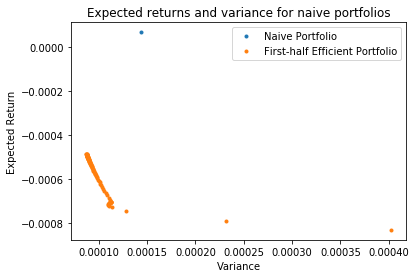

In [33]:
# apply first half efficient portfolios to second half
qn = opt.matrix(assets2, (3, 1))
Sn = opt.matrix(C2)
ef1 = [blas.dot(qn, x) for x in portfolios]
risks1 = [blas.dot(x, Sn*x) for x in portfolios]
ax2.plot(risks1, ef1, 'o', markersize=3, label='First-half Efficient Portfolio')
ax2.legend(loc='best')
fig2